In [ ]:
%%capture
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
!sudo apt-get install imagemagick
import numpy as np
from matplotlib.animation import FuncAnimation

# آ
<div dir='rtl'>

الف ) Discrete Representations

در واقع در این روش به علت نمایش گسسته برای بعضی موارد که به طور ذاتی خاصیت پیوستگی ندارند بهتر است.مانند متن و یا گفتار که کلمات جدا از هم تعریف می شوند معمولا.


ب ) جلوگیری از Posterior Collapse

این مشکل در VAE های معمولی رخ می دهد.

ج ) Probabilistic Discrete Distribution

.

به طور خلاصه بخواهیم بگوییم بهترین ویژگی آن اینست که فضای نهانش گسسته است.بدین ترتیب برای موضوعاتی که موارد از هم جدا هستند و فضای بین آن دو یعنی همان پیوستگی بی معنا میشود از فضای گسسته استفاده می شود.

# ب

In [1]:
%%capture


transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# ج

In [2]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Residual, self).__init__()

        self.layers = nn.Sequential(
            *[nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, num_residual_hiddens, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.Conv2d(num_residual_hiddens, num_hiddens, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(num_hiddens)
            ) for _ in range(num_residual_layers)]
        )

    def forward(self, x):
        return F.relu(x + self.layers(x))

In [3]:


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If the input and output dimensions do not match, use a 1x1 convolution
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out

In [5]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.deconv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out

In [6]:
class QuantizationBlock(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(QuantizationBlock, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # Embedding table
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

        # Initialize embedding weights
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

        self.commitment_cost = commitment_cost

    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embedding.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings


قسمت کوانتیزشن(سلول بالا) با کمک لینک زیر نوشته شد.

https://www.youtube.com/watch?v=VZFVUrYcig0

In [7]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            EncoderBlock(in_channels, num_hiddens // 2),
            EncoderBlock(num_hiddens // 2, num_hiddens),
            *[ResidualBlock(num_hiddens, num_hiddens) for _ in range(num_residual_layers)]
        )

        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,out_channels=embedding_dim,kernel_size=1,stride=1)

        # Quantization Block
        self.quantization = QuantizationBlock(num_embeddings, embedding_dim, commitment_cost)

        # Decoder
        self.decoder = nn.Sequential(
            *[ResidualBlock(embedding_dim, embedding_dim) for _ in range(num_residual_layers)],
            DecoderBlock(embedding_dim, num_hiddens // 2),
            DecoderBlock(num_hiddens // 2, in_channels)
        )

    def forward(self, x):
        # Encoder
        enc_output = self.encoder(x)

        # Quantization

        enc_output = self.pre_vq_conv(enc_output)
        quantization_loss, quantized_output, perplexity, _ = self.quantization(enc_output)
        # print(quantized_output.shape)

        # Decoder
        dec_output = self.decoder(quantized_output)

        return dec_output, quantization_loss, perplexity

# د



In [54]:

def train_model(model, train_loader, optimizer, device, num_epochs=5, display_interval=100):
    model.train()

    losses = []

    codebook=[]

    for epoch in range(num_epochs):
        total_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            # Forward pass
            dec_output, quantization_loss, perplexity = model(data)

            recon_loss = F.mse_loss(dec_output, data)

            total_loss = recon_loss + quantization_loss

            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()


            codebook.append(model.quantization.embedding.weight.data.cpu())
            losses.append(total_loss.item())

            # if (batch_idx + 1) % display_interval == 0:
            #     print(f"Epoch {epoch + 1}/{num_epochs}, Iteration {batch_idx + 1}/{len(train_loader)} => Total Loss: {total_loss.item():.4f}, Recon Loss: {recon_loss.item():.4f}, Perplexity: {perplexity.item():.4f}")

        average_loss = total_loss / len(train_loader)
        # print(f"Epoch {epoch + 1}/{num_epochs} => Average Loss: {average_loss.item():.4f}")

    # plot_loss(losses)
    return codebook,average_loss

def plot_loss(losses):
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Epoch 1/3 => Average Loss: 0.0001
Epoch 2/3 => Average Loss: 0.0000
Epoch 3/3 => Average Loss: 0.0000


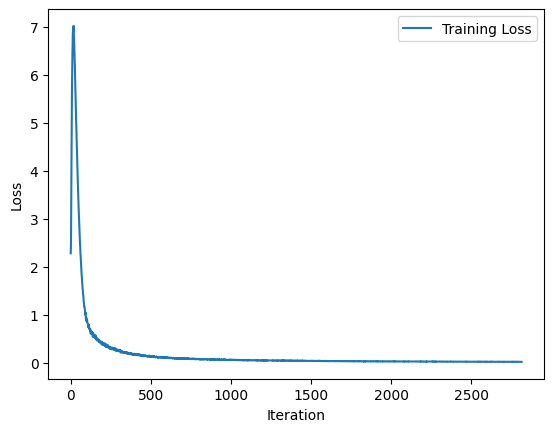

In [9]:
model = VQVAE(in_channels=1, num_hiddens=64, num_residual_layers=5, num_residual_hiddens=32, num_embeddings=256, embedding_dim=32, commitment_cost=0.25)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
codebook,average_loss  = train_model(model, train_loader, optimizer, device, num_epochs=3, display_interval=100)

# ز

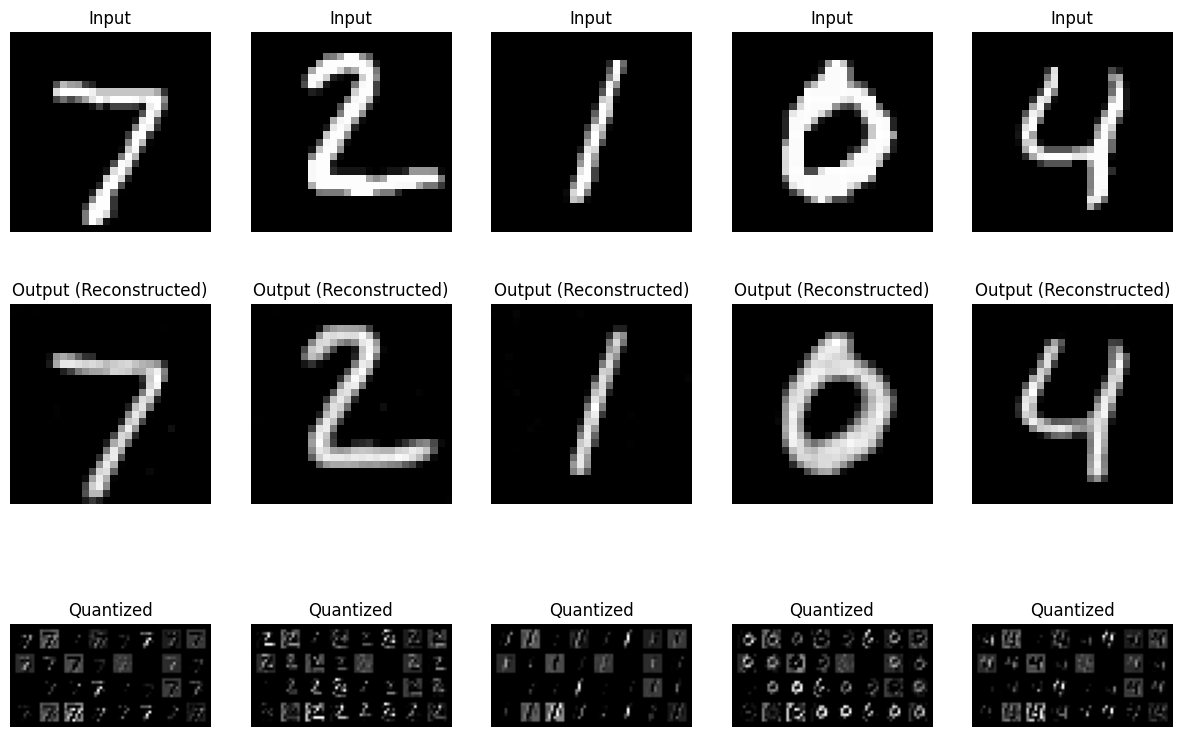

In [10]:

def display(model, valid_loader, num_images):
    model.eval()
    (sample_images, _) = next(iter(valid_loader))
    sample_images = sample_images.to(device)
    sample_images = sample_images[:num_images].to(device)

    with torch.no_grad():
        vq_output_eval = model.pre_vq_conv(model.encoder(sample_images))
        _, valid_quantize, _, _ = model.quantization(vq_output_eval)
        valid_recons = model.decoder(valid_quantize)

    plt.figure(figsize=(15, 10))

    # Display input images
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(sample_images[i].cpu().squeeze().numpy(), cmap='gray')  # Use cmap='gray'
        plt.title('Input')
        plt.axis('off')

    # Display model output (decoded)
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(valid_recons[i].cpu().squeeze().numpy(), cmap='gray')  # Use cmap='gray'
        plt.title('Output (Reconstructed)')
        plt.axis('off')

    # Display quantized output
    for i in range(num_images):
        u = valid_quantize[i].view(model.quantization.embedding_dim, 7, 7).cpu().data.unsqueeze(1)
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(make_grid(u).squeeze().permute(1, 2, 0).numpy(), cmap='gray')  # Use cmap='gray'
        plt.title('Quantized')
        plt.axis('off')

    plt.show()

display(model, test_loader, num_images=5)


Epoch 1/3 => Average Loss: 0.0001
Epoch 2/3 => Average Loss: 0.0001
Epoch 3/3 => Average Loss: 0.0001


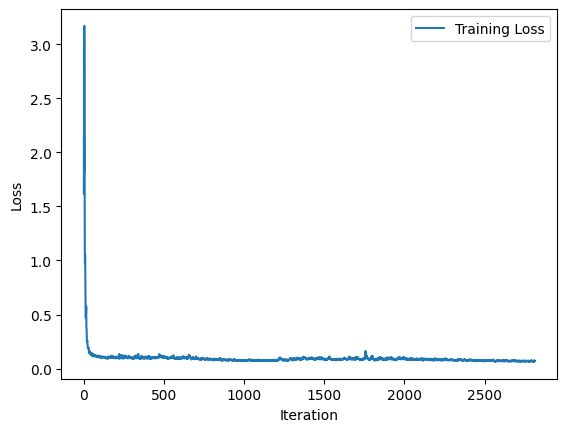

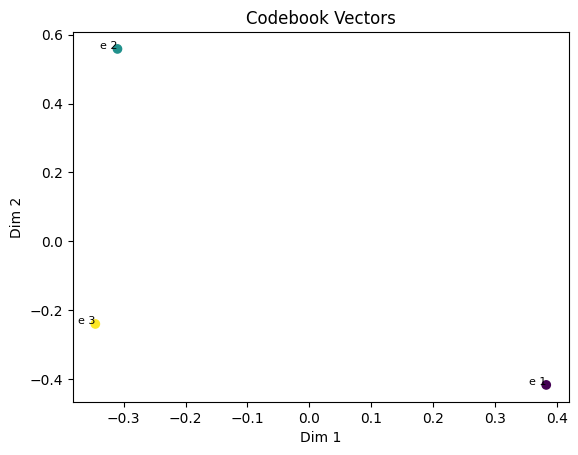

In [11]:
model = VQVAE(in_channels=1, num_hiddens=64, num_residual_layers=5, num_residual_hiddens=32, num_embeddings=3, embedding_dim=2, commitment_cost=0.25)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
codebook,average_loss = train_model(model, train_loader, optimizer, device, num_epochs=3, display_interval=100)

labels = [1, 2, 3]
u=codebook[-1]
plt.scatter(u[:, 0], u[:, 1], c=labels)
plt.title("Codebook Vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

for i, label in enumerate(labels):
    plt.text(u[i, 0], u[i, 1], f'e {label}', fontsize=8, ha='right')
plt.show()


# ح

In [50]:

num_points = 3
num_frames = 200
u=codebook[:num_frames]
point_names = ['e1', 'e2', 'e3']

def update(frame):
    plt.cla()

    current_data = u[frame]
    scatter = plt.scatter(current_data[:, 0], current_data[:, 1], c=[1, 2, 3], marker='o')
    for i, txt in enumerate(point_names):
        plt.text(current_data[i, 0], current_data[i, 1], txt, fontsize=8, ha='right')

    plt.title(f'Frame {frame}')
    plt.xlabel('dim 1')
    plt.ylabel('dim2')
animation = FuncAnimation(plt.figure(), update, frames=num_frames, interval=0.1)

animation.save('animation1.gif', writer='imagemagick')
plt.show()


<div dir='rtl'>

با توجه به انیمیشن ساخته شده که در فایل زیپ قرار دارد مشاهده می شود که رفته رفته سعی می شود فاصله بین بردار ها افزایش پیدا کند.

# ط

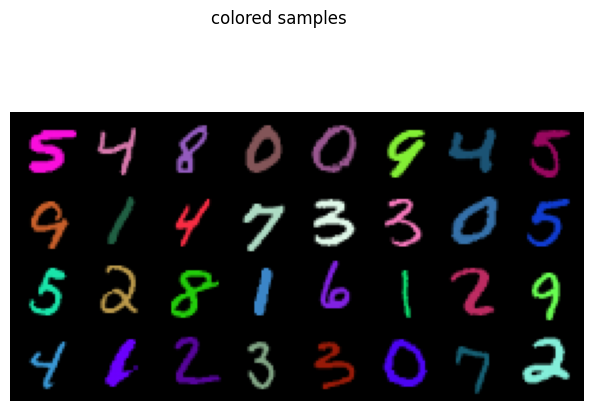

In [53]:
colored_trainDataset = [(img.repeat(3, 1, 1) * torch.rand(3,1,1), label) for img, label in train_dataset]
colored_testDataset = [(img.repeat(3, 1, 1) * torch.rand(3,1,1), label) for img, label in test_dataset]

colored_train_loader = DataLoader(colored_trainDataset, batch_size=32, shuffle=True)
colored_test_loader = DataLoader(colored_testDataset, batch_size=32, shuffle=True)

npimg = make_grid(next(iter(colored_test_loader))[0].cpu(), nrow=8, normalize=True).numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.suptitle("colored samples")
plt.tight_layout()
plt.axis('off')
plt.show()


In [56]:
def display(model, test_loader):
    model.eval()
    (sample_images, _) = next(iter(test_loader))
    sample_images = sample_images.to(device)
    with torch.no_grad():
        valid_recons,_,_ = model(sample_images)

    npimg = make_grid(valid_recons.cpu(), nrow=8, normalize=True).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.suptitle("colored samples")
    plt.tight_layout()
    plt.axis('off')
    plt.show()

for num_embeddings=3


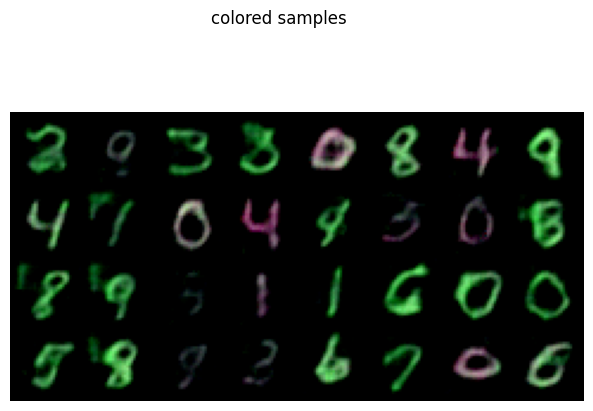

for num_embeddings=13


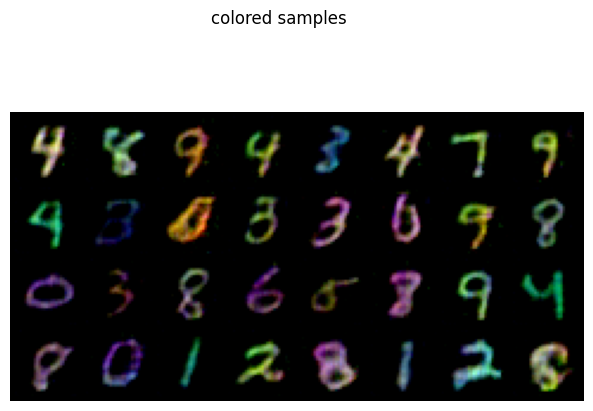

for num_embeddings=23


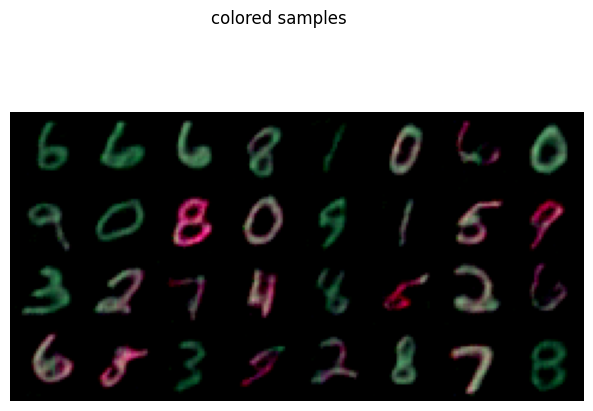

for num_embeddings=33


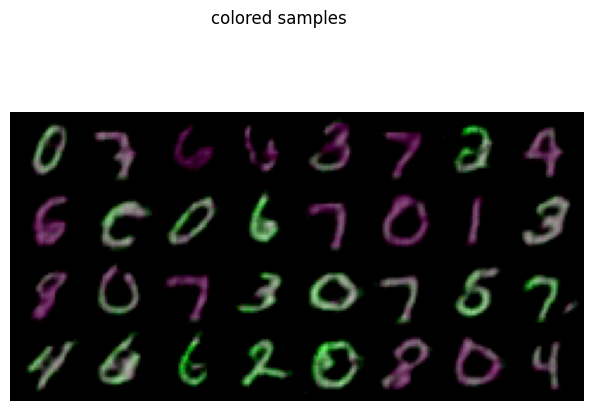

for num_embeddings=43


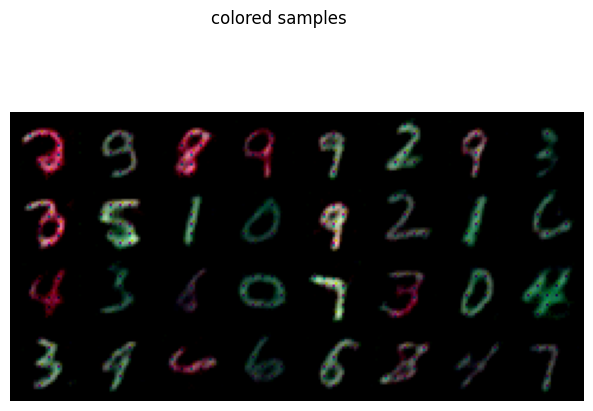

In [57]:
for i in range(3,53,10):
    model = VQVAE(in_channels=3, num_hiddens=64, num_residual_layers=5, num_residual_hiddens=32, num_embeddings=i, embedding_dim=2, commitment_cost=0.25)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    codebook,average_loss = train_model(model, colored_train_loader, optimizer, device, num_epochs=3, display_interval=100)
    print(f'for num_embeddings={i}')
    display(model, colored_test_loader)

for embedding_dim=2


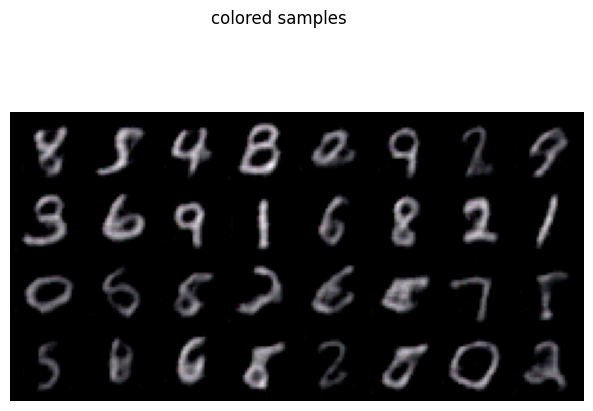

for embedding_dim=12


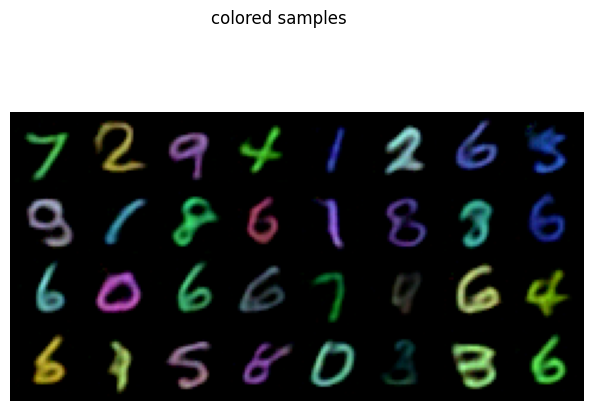

for embedding_dim=22


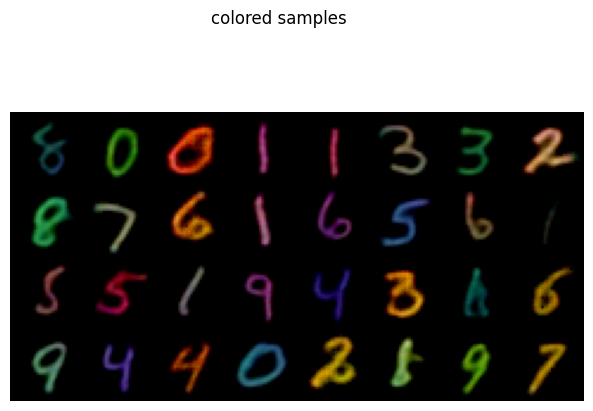

for embedding_dim=32


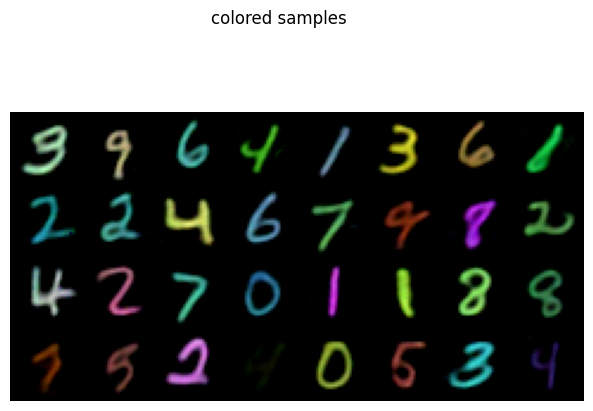

for embedding_dim=42


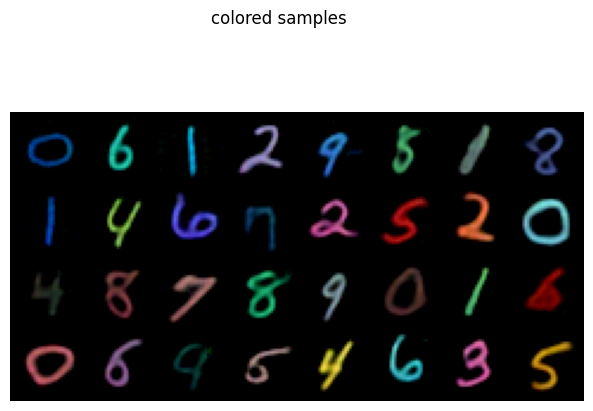

In [58]:
for i in range(2,52,10):
    model = VQVAE(in_channels=3, num_hiddens=64, num_residual_layers=5, num_residual_hiddens=32, num_embeddings=3, embedding_dim=i, commitment_cost=0.25)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    codebook,average_loss = train_model(model, colored_train_loader, optimizer, device, num_epochs=3, display_interval=100)
    print(f'for embedding_dim={i}')
    display(model, colored_test_loader)

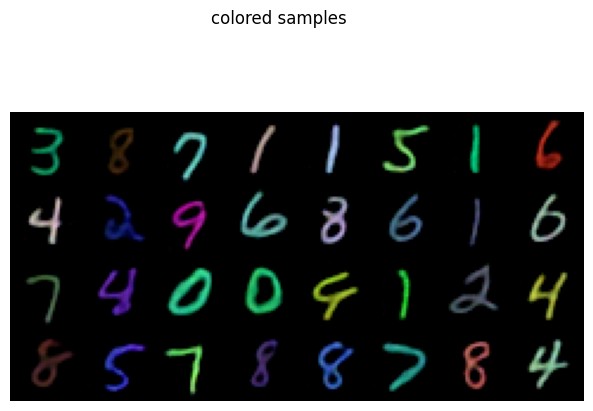

In [60]:
model = VQVAE(in_channels=3, num_hiddens=64, num_residual_layers=5, num_residual_hiddens=32, num_embeddings=512, embedding_dim=32, commitment_cost=0.25)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
codebook,average_loss = train_model(model, colored_train_loader, optimizer, device, num_epochs=3, display_interval=100)
display(model, colored_test_loader)

<div dir='rtl'>

با توجه به نتایج مشاهده می شود افزایش ابعاد بردار ها تاثیر بیشتری نسبت به افزایش تعداد بردار ها داشته است و تصاویر بهتر بازیابی شده اند.